# Introduction

Entre mai 2009 et avril 2010, la France avait compté 20 800 hospitalisations et 280 décès dûs à des intoxications alimentaires. Afin de réduire ce nombre d'incident, nous avons pris l'initiative de créer une solution de Business Intelligence Microsoft. Cette solution devra être capable de détecter les restaurants susceptibles d'être responsable d'une nouvelle intoxication alimentaire avec une fiabilité de plus de 80 %.

# Méthodologie

La solution de Business Intelligence sera découpée en 4 parties :

- Un script Python et différents composants SSIS qui récupéreront les données depuis les sites TripAdvisor, AlimConfiance et Data.Gouv.

- Une solution SSIS qui alimentera un entrepôt de données SQL Server 2017.

- Une solution SSAS qui modélisera les données et qui y appliquera un algorithme de classification des restaurants.

- Un rapport Power BI qui restitura les données provenant du cube SSAS.
    

Dans ce document Jupyter Notebook, nous allons uniquement :

 - Utiliser un script de scrapping écrit en Python et nommé scrapping_script.py.
 
 - Concevoir un premier modèle d'intelligence artificielle en Python pour classifier les restaurants.
 

PS : Le script de scrapping aura été préalablement conçu pour parcourir et récupérer les informations de plus de 13 258 pages webs contenant des informations sur des restaurants parisiens. Son temps d'exécution est donc estimé à environ 12 heures.

### Liste des libraries Python utilisées

In [1]:
import requests
import re
import pandas as pd
import time
import numpy as np
import os
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import recall_score

from scrapping_script import main_restaurants_scrapping
from scrapping_script import main_restaurants_details_scrapping

### Source des données

Pour élaborer ce projet, nous utiliserons 4 fichiers csv :

 - Le fichier "restaurants.csv" qui recense le nom et les liens TripAdvisor des restaurants situés en Ile de France.
 
 - Le fichier "restaurants_overview.csv" qui recense des informations globales sur les restaurants du fichier "restaurants.csv".
 
 - Le fichier "restaurants_comments.csv" qui recense des commentaires d'internautes TripAdvisor sur les restaurants du fichier "restaurants.csv".
 
 - Le fichier "export_alimconfiance.csv" qui recence les évaluations sanitaires des restaurants français.

# Pipeline de machine learning

### Scrapping des données de TripAdvisor (Dernière exécution le 28 août 2019).

In [2]:
#main_restaurants_scrapping(550)
#restaurants = pd.read_csv('restaurants.csv')
#main_restaurants_details_scrapping(restaurants)

### Ouverture et fusion des différentes sources de données.

In [3]:
# Reading of the files

restaurants = pd.read_csv('restaurants.csv')
restaurants_overview = pd.read_csv('restaurants_overview.csv', sep='|')
restaurants_comments = pd.read_csv('restaurants_comments.csv', sep='|')
labels = pd.read_csv('export_alimconfiance.csv', sep=';')


# Renaming of the columns

restaurants.columns = ['Restaurant_Name', 'Restaurant_URL']

columns = ['Rating', 'Comment_Count', 'ZIPCODE', 'Restaurant_Url']
restaurants_overview = restaurants_overview[columns]
restaurants_overview.columns = ['Restaurant_Rating', 'Restaurant_Comment_Count', 'ZIPCODE', 'Restaurant_URL']

columns = ['Rating','Date', 'Title', 'Comment', 'Visit_date', 'Restaurant_Url']
restaurants_comments = restaurants_comments[columns]
restaurants_comments.columns = ['Comment_Rating', 'Publish_Date',
                                'Comment_Title', 'Comment_Content',
                                'Visit_Date', 'Restaurant_URL']

columns = ['APP_Libelle_etablissement', 'Code_postal', 'Synthese_eval_sanit', 'Date_inspection']
labels = labels[columns]
labels.columns = ['Restaurant_Name', 'ZIPCODE', 'Label', 'Inspection_Date']


# Transformation of the columns used for the inner join

restaurants['Restaurant_Name'] = restaurants['Restaurant_Name'].str.upper()
restaurants_overview['ZIPCODE'] = restaurants_overview['ZIPCODE'].astype(str).str.extract('(\d*)\.0')

labels['Restaurant_Name'] = labels['Restaurant_Name'].astype(str)
labels['ZIPCODE'] = labels['ZIPCODE'].astype(str)


# Inner join

dataset = pd.merge(restaurants, restaurants_overview, how='inner', on='Restaurant_URL')
dataset = pd.merge(dataset, restaurants_comments, how='inner', on='Restaurant_URL')
dataset = pd.merge(dataset, labels, how='inner', on=['Restaurant_Name', 'ZIPCODE'])

### Exploration avant nettoyage des données et feature engineering.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13022 entries, 0 to 13021
Data columns (total 12 columns):
Restaurant_Name             13022 non-null object
Restaurant_URL              13022 non-null object
Restaurant_Rating           13022 non-null object
Restaurant_Comment_Count    13022 non-null int64
ZIPCODE                     13022 non-null object
Comment_Rating              13022 non-null int64
Publish_Date                13022 non-null object
Comment_Title               12967 non-null object
Comment_Content             12981 non-null object
Visit_Date                  13022 non-null object
Label                       13022 non-null object
Inspection_Date             13022 non-null object
dtypes: int64(2), object(10)
memory usage: 1.3+ MB


In [5]:
dataset.head(3)

,Restaurant_Name,Restaurant_URL,Restaurant_Rating,Restaurant_Comment_Count,ZIPCODE,Comment_Rating,Publish_Date,Comment_Title,Comment_Content,Visit_Date,Label,Inspection_Date
0,IL ETAIT UN SQUARE,https://www.tripadvisor.fr/Restaurant_Review-g...,5,2928,75013,5,27/08/2019,Ce resto mérite plus que 5 étoiles !,Le personnel est très agréable et cela fait pl...,01/08/2019,Satisfaisant,2019-01-30T01:00:00+01:00
1,IL ETAIT UN SQUARE,https://www.tripadvisor.fr/Restaurant_Review-g...,5,2928,75013,5,26/08/2019,Les voisins de place d'Italie,Très bon burger sa réputation du meilleur burg...,01/08/2019,Satisfaisant,2019-01-30T01:00:00+01:00
2,IL ETAIT UN SQUARE,https://www.tripadvisor.fr/Restaurant_Review-g...,5,2928,75013,5,17/08/2019,Bonne expérience,Restaurant victime de son succès mais succès m...,01/07/2019,Satisfaisant,2019-01-30T01:00:00+01:00


Après une première exploration des données, nous pouvons constater que le jeu de donnée comporte 13022 observations, 10 colonnes de features et 1 colonne de label.

Nous pouvons également constater les problèmes suivants :

- Plusieurs variables n'apporteront pas de valeur à notre modèle.

- La plupart des variables (features + label) n'ont pas le bon type de donnée.

- Le fait que des commentaires ont été publié après la date d'inspection, peut entrainer un dataleak.

- Les colonnes Comment_Title et Comment_Content contiennent du langage naturel.

- Il existe des valeurs inconnues dans les colonnes Comment_Title et Comment_Content.

- Il n'est actuellement pas possible de vérifier l'équilibrage des labels.

- Il existe plusieurs observations (commentaires) pour un même restaurant.

### Nettoyage des données

Lors de ce nettoyage de données, nous allons résoudre 3 sur 7 des problèmes constatés en :

- Faisant une sélection des variables utiles à notre étude.

- Transformant le type des variables au bon format. 

- Filtrant uniquement les commentaires qui auront été publiés les 120 jours qui précèdent l'évaluation sanitaire du gourvenement.

In [6]:
# Selection of the useful variables

columns = ['Restaurant_Rating', 'Restaurant_Comment_Count', 'Comment_Rating',
           'Publish_Date', 'Visit_Date', 'Comment_Title', 'Comment_Content',
           'Inspection_Date', 'Label', 'Restaurant_URL']

dataset = dataset[columns]


# Casting of the variables

int_variables = ['Restaurant_Rating', 'Restaurant_Comment_Count', 'Comment_Rating' ]

date_variables = ['Publish_Date', 'Visit_Date', 'Inspection_Date']

str_variables = ['Comment_Title', 'Comment_Content']


for variable in int_variables:
    dataset[variable] = dataset[variable].astype(int)

for variable in date_variables:
    dataset[variable] = pd.to_datetime(dataset[variable], utc=True)
    
for variable in str_variables:
    dataset[variable] = dataset[variable].astype(str)
    
    
# Dataleak prevention

dataset['Validity_Start'] = dataset['Inspection_Date'] - pd.Timedelta(days=120)

condition_1 = (dataset['Publish_Date'] >= dataset['Validity_Start'])
condition_2 = (dataset['Publish_Date'] < dataset['Inspection_Date'])

dataset = dataset.loc[condition_1 & condition_2]
dataset = dataset.drop(['Validity_Start', 'Inspection_Date'], axis = 1)

### Feature Engineering

Lors de ce feature engineering, nous allons résoudre 4 sur 7 des problèmes constatés en :

- Réduisant les variables Publish_Date et Visit_Date à une seule variable.

- Faisant un recodage de la variable des labels.

- Recodant les variables Comment_Title et Comment_Content en nombre de token qu'ils contiennent.

- Aggrégeant toute les données numériques du jeu de donnée par restaurant et non par commentaire.

In [7]:
# Reaction Time

dataset['Reaction_Time'] = dataset['Publish_Date'] - dataset['Visit_Date']
dataset['Reaction_Time'] = dataset['Reaction_Time'].dt.days

mask = dataset['Reaction_Time'] >= 0
dataset['Reaction_Time'].loc[~mask] = 0
dataset['Reaction_Time'] = dataset['Reaction_Time'].astype(int)

dataset = dataset.drop(['Publish_Date', 'Visit_Date'], axis = 1)


# Label transformation

encoding = {'Satisfaisant':0,
            'Très satisfaisant':0,
            'A améliorer':1,
            'A corriger de manière urgente':1}

dataset['Label'] = dataset['Label'].replace(encoding.keys(), encoding.values(), regex=True)


# Token Count

dataset['Token_Title_Count'] = dataset['Comment_Title'].apply(lambda x : len(word_tokenize(x)))
dataset['Token_Content_Count'] = dataset['Comment_Content'].apply(lambda x : len(word_tokenize(x)))

dataset = dataset.drop(['Comment_Title', 'Comment_Content'], axis = 1)


# Row aggregation by restaurant

dataset = dataset.groupby('Restaurant_URL').mean().round()

C:\Users\Administrator\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Exploration après nettoyage des données et feature engineering.

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, https://www.tripadvisor.fr/Restaurant_Review-g187147-d10031140-Reviews-Terre_de_Crete-Paris_Ile_de_France.html to https://www.tripadvisor.fr/Restaurant_Review-g187147-d9866676-Reviews-Subway-Paris_Ile_de_France.html
Data columns (total 7 columns):
Restaurant_Rating           843 non-null float64
Restaurant_Comment_Count    843 non-null float64
Comment_Rating              843 non-null float64
Label                       843 non-null float64
Reaction_Time               843 non-null float64
Token_Title_Count           843 non-null float64
Token_Content_Count         843 non-null float64
dtypes: float64(7)
memory usage: 52.7+ KB


[]

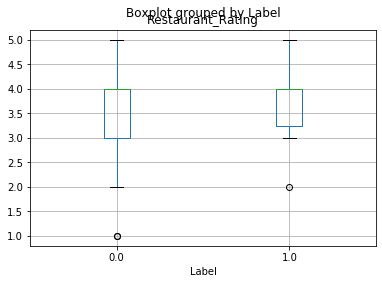

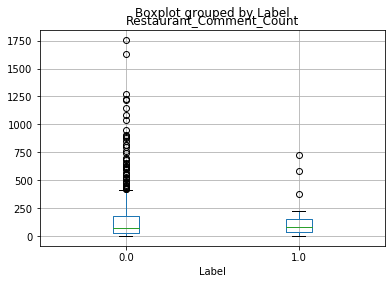

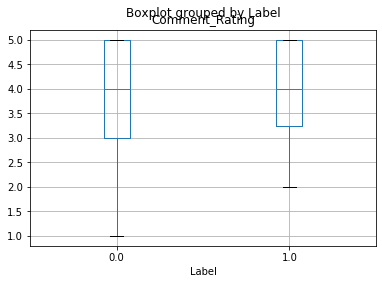

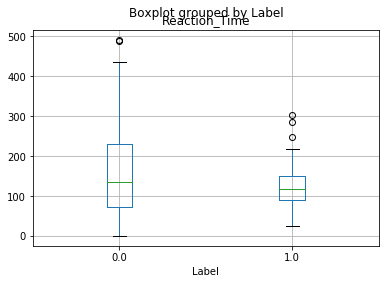

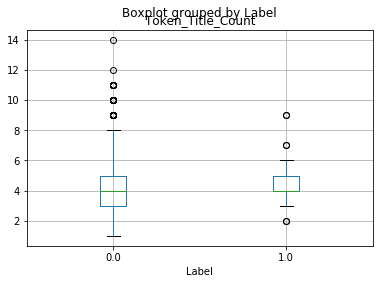

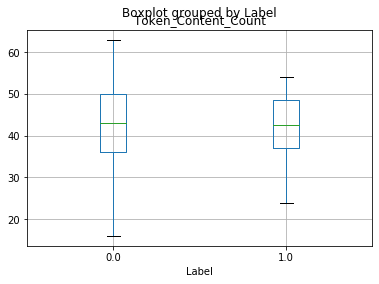

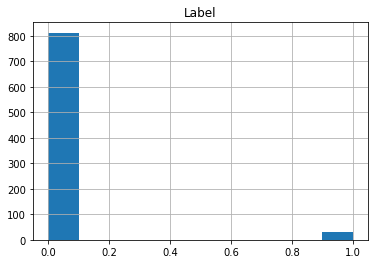

In [35]:
dataset.boxplot('Restaurant_Rating', by='Label')
dataset.boxplot('Restaurant_Comment_Count', by='Label')
dataset.boxplot('Comment_Rating', by='Label')
dataset.boxplot('Reaction_Time', by='Label')
dataset.boxplot('Token_Title_Count', by='Label')
dataset.boxplot('Token_Content_Count', by='Label')
dataset.hist('Label')
plt.plot()

Après une seconde exploration des données, nous pouvons affirmer que :

- Le nombre d'observation est descendu à 843 et le nombre de variable à 7.

- Le nombre de commentaire est plus important pour les restaurants ayant eu une évaluation négative que les restaurants ayant eu une évaluation positive.

- Le nombre de jours écoulé entre la visite du restaurant et la publication d'un avis TripAdvisor, est moins important pour les restaurants ayant eu une évaluation négative.

- Il y a davantage de restaurants ayant une évaluation positive qu'une évaluation négative.



### Equilibrage des labels

[]

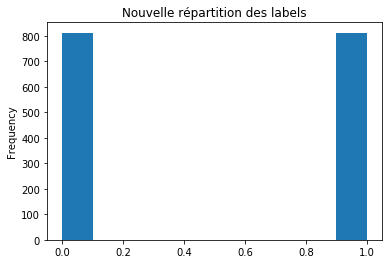

In [31]:
over_sampler = SMOTE()
X_resampled, y_resampled = over_sampler.fit_sample(dataset.drop('Label', axis=1), dataset['Label'])

pd.Series(y_resampled).plot(kind='hist', title = 'Nouvelle répartition des labels')
plt.plot()

### Entrainement d'un modèle de référence

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

LogisticRegression_Model = LogisticRegressionCV(cv=10)
LogisticRegression_Model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

### Evaluation du modèle de référence

In [12]:
y_predict = LogisticRegression_Model.predict(X_test)
recall_score(y_test, y_predict)

0.7345971563981043

Le modèle de référence à une fiabilité de plus de 70 % et non 80 %. Nous allons donc optimiser le traitement de données avant d'envisager d'utiliser des modèles de classification (Decision tree, Random Forest...) plus performants.

# Bibliographie

Statistiques sur les intoxications alimentaires françaises : https://www.pseudo-sciences.org/Les-intoxications-alimentaires-en-France-quelle-ampleur

TripAdvisor : https://www.tripadvisor.fr

AlimConfiance : https://dgal.opendatasoft.com/explore/dataset/export_alimconfiance/download/?format=csv&disjunctive.filtre=true&disjunctive.app_libelle_activite_etablissement=true&disjunctive.ods_type_activite=true&refine.filtre=Restaurant&timezone=Europe/Berlin&use_labels_for_header=true